## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install additional dependencies
# !pip install pandas pillow tqdm

# # Install package for creating visually distinct colormaps
# !pip install distinctipy

# # Install utility packages
# !pip install cjm_psl_utils

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from glob import glob
from pathlib import Path

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract

# Import the distinctipy module
from distinctipy import distinctipy

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import XML support
import xml.etree.ElementTree as ET
import xml.dom.minidom

## Loading and Exploring the Dataset

### Setting the Directory Paths

In [3]:
# Define path to store datasets
dataset_dir = Path("./Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Dataset Directory:,/mnt/980_1TB_2/Datasets
Archive Directory:,/mnt/980_1TB_2/Datasets/../Archive


### Setting the Dataset Path

In [4]:
# Set the name of the dataset
dataset_name = 'labelme-instance-segmentation-toy-dataset'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

# Creating a Series with the dataset name and paths and converting it to a DataFrame for display
pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/labelme-instance-segmentation-toy-dataset
Archive Path:,/mnt/980_1TB_2/Datasets/../Archive/labelme-instance-segmentation-toy-dataset.zip
Dataset Path:,/mnt/980_1TB_2/Datasets/labelme-instance-segmentation-toy-dataset


### Downloading the Dataset

In [5]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{dataset_name}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_dir)    
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/labelme-instance-segmentation-toy-dataset/resolve/main/labelme-instance-segmentation-toy-dataset.zip
Dataset folder already exists


### Getting the Image and Annotation Files

In [6]:
# Get a list of JSON files in the dataset
annotation_file_paths = list(dataset_path.glob('*.json'))

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Annotation File":[file.name for file in annotation_file_paths]}).head()

,Annotation File
0,258421.json
1,3075367.json
2,3076319.json
3,3145551.json
4,3176048.json


### Get Image Annotations

In [7]:
# Create a generator that yields Pandas DataFrames containing the data from each JSON file
cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths))

# Concatenate the DataFrames into a single DataFrame
annotation_df = pd.concat(cls_dataframes, ignore_index=False)

# Assign the image file name as the index for each row
annotation_df['index'] = annotation_df.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
annotation_df = annotation_df.set_index('index')

# Print the first 5 rows of the DataFrame
annotation_df.head()

  0%|          | 0/31 [00:00<?, ?it/s]

,version,flags,shapes,imagePath,imageData,imageHeight,imageWidth
index,,,,,,,
258421,5.3.1,{},"[{'label': 'person', 'points': [[404.0, 775.5], [396.5, 766.0], [411.5, 753.0], [411.5, 738.0], [416.5, 731.0], [412.5, 598.0], [419.5, 559.0], [416.0, 554.5], [404.0, 566.5], [387.0, 572.5], [375.5, 566.0], [377.5, 554.0], [405.5, 529.0], [413.5, 504.0], [414.5, 493.0], [386.5, 463.0], [388.5, 453.0], [399.0, 443.5], [413.0, 444.5], [423.5, 453.0], [457.5, 506.0], [452.5, 575.0], [458.5, 607.0], [447.5, 635.0], [444.5, 676.0], [452.5, 764.0], [443.0, 770.5]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[377.0, 775.5], [368.0, 774.5], [346.5, 764.0], [349.5, 751.0], [348.5, 707.0], [358.5, 668.0], [343.5, 651.0], [359.5, 605.0], [379.5, 583.0], [366.00692041522484, 583.3910034602076], [362.5467128027681, 575.7785467128027], [361.85467128027676, 565.3979238754325], [353.2041522491349, 557.0934256055363], [357.7024221453287, 547.4048442906574], [350.7820069204152, 532.5259515570934], [356.31833910034595, 520.7612456747405], [359.7785467128027, 481.31487889273353], [376.3875432525951, 467.47404844290656], [387.4602076124567, 469.5501730103806], [401.3010380622837, 484.08304498269894], [405.79930795847747, 501.038062283737], [394.03460207612454, 505.88235294117646], [394.72664359861585, 519.0311418685121], [399.916955017301, 531.1418685121107], [374.6574394463667, 554.3252595155709], [369.81314878892726, 571.280276816609], [374.31141868512105, 574.0484429065743], [388.152249134948, 574.39446366782], [397.49480968858126, 569.8961937716263], [402.5, 578.0], [410.5, 594.0], [412.5, 668.0], [387.0, 667.5], [375.5, 692.0], [376.5, 738.0], [380.5, 753.0], [388.5, 764.0], [386.5, 772.0]], 'group_id': None, 'description': None, 'shape_type': 'polygon', 'flags': {}}]",258421.jpg,None,1152,768
3075367,5.3.1,{},"[{'label': 'person', 'points': [[714.0, 766.5], [664.0, 765.5], [654.0, 716.5], [640.0, 765.5], [578.5, 764.0], [578.5, 599.0], [570.5, 587.0], [592.5, 403.0], [583.5, 339.0], [525.5, 278.0], [463.5, 187.0], [423.5, 98.0], [422.5, 72.0], [444.0, 52.5], [460.5, 62.0], [458.5, 104.0], [485.5, 166.0], [581.0, 270.5], [623.0, 295.5], [644.5, 293.0], [630.5, 261.0], [642.5, 193.0], [667.0, 182.5], [707.0, 191.5], [719.5, 249.0], [709.0, 307.5], [774.0, 271.5], [848.5, 176.0], [875.5, 108.0], [867.5, 55.0], [902.0, 63.5], [908.5, 76.0], [902.5, 134.0], [858.5, 233.0], [759.5, 350.0], [736.5, 495.0], [752.5, 614.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[829.0, 466.5], [825.5, 464.0], [824.5, 455.0], [825.5, 425.0], [828.0, 419.5], [833.5, 418.0], [827.5, 417.0], [822.5, 396.0], [825.5, 327.0], [843.5, 313.0], [842.5, 296.0], [833.5, 291.0], [832.5, 270.0], [837.0, 265.5], [856.0, 264.5], [868.5, 277.0], [870.5, 306.0], [881.5, 318.0], [883.5, 329.0], [893.0, 332.5], [899.5, 340.0], [901.5, 367.0], [883.5, 382.0], [849.5, 443.0], [842.5, 448.0], [838.5, 460.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[359.0, 509.5], [355.0, 509.5], [350.5, 502.0], [353.5, 486.0], [349.5, 475.0], [349.5, 449.0], [345.5, 430.0], [339.5, 419.0], [337.5, 394.0], [327.5, 378.0], [331.5, 371.0], [332.5, 357.0], [342.5, 345.0], [345.5, 327.0], [354.0, 313.5], [365.5, 317.0], [366.5, 339.0], [385.0, 350.5], [399.5, 371.0], [398.5, 383.0], [390.0, 391.5], [390.5, 378.0], [383.0, 369.5], [379.5, 370.0], [380.5, 441.0], [376.5, 471.0], [370.0, 464.5], [364.5, 472.0], [362.5, 482.0], [364.5, 504.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'car', 'points': [[1343.0, 764.5], [964.0, 745.5], [930.0, 764.5], [914.5, 759.0], [904.0, 722.5], [865.0, 706.5], [848.0, 735.5], [801.0, 735.5], [788.5, 699.0], [792.5, 577.0], [821.5, 476.0], [849.5, 454.0], [890.5, 382.0], [930.0, 355.5], [1021.0, 347.5], [1195.0, 358.5], [1287.0, 378.5], [1343

#### Get image classes

In [8]:
# Explode the 'shapes' column in the annotation_df dataframe
# Convert the resulting series to a dataframe and rename the 'shapes' column to 'shapes'
# Apply the pandas Series function to the 'shapes' column of the dataframe
shapes_df = annotation_df['shapes'].explode().to_frame().shapes.apply(pd.Series)

# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = shapes_df['label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,person
1,car


#### Generate a color map

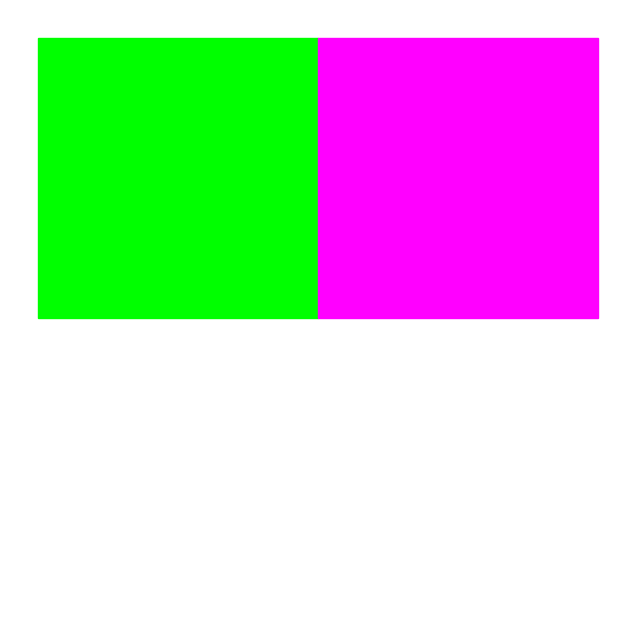

In [9]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [10]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Inspect the corresponding annotation data

In [11]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.iloc[0].to_frame()

,258421
version,5.3.1
flags,{}
shapes,"[{'label': 'person', 'points': [[404.0, 775.5], [396.5, 766.0], [411.5, 753.0], [411.5, 738.0], [416.5, 731.0], [412.5, 598.0], [419.5, 559.0], [416.0, 554.5], [404.0, 566.5], [387.0, 572.5], [375.5, 566.0], [377.5, 554.0], [405.5, 529.0], [413.5, 504.0], [414.5, 493.0], [386.5, 463.0], [388.5, 453.0], [399.0, 443.5], [413.0, 444.5], [423.5, 453.0], [457.5, 506.0], [452.5, 575.0], [458.5, 607.0], [447.5, 635.0], [444.5, 676.0], [452.5, 764.0], [443.0, 770.5]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[377.0, 775.5], [368.0, 774.5], [346.5, 764.0], [349.5, 751.0], [348.5, 707.0], [358.5, 668.0], [343.5, 651.0], [359.5, 605.0], [379.5, 583.0], [366.00692041522484, 583.3910034602076], [362.5467128027681, 575.7785467128027], [361.85467128027676, 565.3979238754325], [353.2041522491349, 557.0934256055363], [357.7024221453287, 547.4048442906574], [350.7820069204152, 532.5259515570934], [356.31833910034595, 520.7612456747405], [359.7785467128027, 481.31487889273353], [376.3875432525951, 467.47404844290656], [387.4602076124567, 469.5501730103806], [401.3010380622837, 484.08304498269894], [405.79930795847747, 501.038062283737], [394.03460207612454, 505.88235294117646], [394.72664359861585, 519.0311418685121], [399.916955017301, 531.1418685121107], [374.6574394463667, 554.3252595155709], [369.81314878892726, 571.280276816609], [374.31141868512105, 574.0484429065743], [388.152249134948, 574.39446366782], [397.49480968858126, 569.8961937716263], [402.5, 578.0], [410.5, 594.0], [412.5, 668.0], [387.0, 667.5], [375.5, 692.0], [376.5, 738.0], [380.5, 753.0], [388.5, 764.0], [386.5, 772.0]], 'group_id': None, 'description': None, 'shape_type': 'polygon', 'flags': {}}]"
imagePath,258421.jpg
imageData,None
imageHeight,1152
imageWidth,768


## Saving Annotations to CVAT XML Format

### Define Utility Functions

#### Define a function to format the generated XML content

In [12]:
def prettify(elem):
    """
    Return a pretty-printed XML string for the Element.

    Args:
    elem (xml.etree.ElementTree.Element): The XML element to be pretty-printed.

    Returns:
    str: A pretty-printed XML string.
    """
    # Convert the XML element to a string with utf-8 encoding
    rough_string = ET.tostring(elem, 'utf-8')
    # Parse the string back into an XML document
    reparsed = xml.dom.minidom.parseString(rough_string)
    # Return the pretty-printed string with an indentation
    return reparsed.toprettyxml(indent="  ")

#### Define a function to store keypoint coordinates in CVAT XML format

In [13]:
def convert_keypoints(keypoints):
    """
    Convert a list of keypoints to a format suitable for CVAT annotation.

    This function processes keypoints for each image, converting them into a dictionary
    format required by CVAT (Computer Vision Annotation Tool).

    Args:
    - keypoints (list of list of dicts): A nested list where each sublist represents keypoints
      for an image, and each keypoint is a dictionary mapping labels to coordinates.

    Returns:
    - list of list of dicts: The converted keypoints, where each keypoint is represented as
      a dictionary with 'label' and 'points' as keys.
    """
    converted = []
    for image_keypoints in keypoints:
        image_converted = []
        for keypoint in image_keypoints:
            for label, coords in keypoint.items():
                # Converting coordinates to a comma-separated string
                cvat_keypoint = {
                    "label": label,
                    "points": ",".join(map(str, coords))  # e.g., "x1,y1,x2,y2,..."
                }
                image_converted.append(cvat_keypoint)
        converted.append(image_converted)
    return converted

#### Define a function to save segmentation annotations to a CVAT XML file

In [14]:
def create_cvat_segmentetion_xml(labels, polygon_points, colors, dims, image_names, file_name):
    """
    Creates an XML file formatted for CVAT annotation with segmentation information.

    Parameters:
    labels (list of str): The list of label names for the segments.
    polygon_points (list of list of dicts): Each list contains dictionaries with 'label' and 'points' for one image.
    colors (list of tuples): RGB color tuples for each label.
    dims (list of tuples): Dimensions (width, height) for each image.
    image_names (list of str): The list of image file names.
    file_name (str): The name of the output XML file.

    This function converts polygon points, creates an XML structure for CVAT annotation, 
    and writes it to an XML file.
    """

    # Convert polygon points if needed (function 'convert_polygon_points' should be defined elsewhere)
    converted_points = convert_keypoints(polygon_points)

    # Create the root XML element 'annotations'
    annotations = ET.Element("annotations")

    # Add version information to the XML
    version = ET.SubElement(annotations, "version")
    version.text = "1.1"

    # Create a 'meta' section with task details
    meta = ET.SubElement(annotations, "meta")
    task = ET.SubElement(meta, "task")
    ET.SubElement(task, "id").text = "1"  # Example ID
    ET.SubElement(task, "name").text = "Image Annotation Task"
    ET.SubElement(task, "size").text = str(len(dims))  # Number of images
    ET.SubElement(task, "mode").text = "annotation"
    ET.SubElement(task, "overlap").text = "0"

    # Add label information within the task
    labels_elem = ET.SubElement(task, "labels")
    for label, color in zip(labels, colors):
        label_elem = ET.SubElement(labels_elem, "label")
        ET.SubElement(label_elem, "name").text = label
        # Convert RGB color to hex format
        ET.SubElement(label_elem, "color").text = f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}"
        ET.SubElement(label_elem, "type").text = "polygon"

    # Add image and polygon information
    for i, (dim, points_per_image, image_name) in enumerate(zip(dims, converted_points, image_names)):
        # Create an 'image' element for each image
        image_elem = ET.SubElement(annotations, "image", id=str(i), name=image_name, width=str(dim[0]), height=str(dim[1]))
        # Add each polygon point as a child of the image element
        for keypoint in points_per_image:
            ET.SubElement(image_elem, "polygon", label=keypoint["label"], points=keypoint["points"], occluded="0")

    # Write the XML to a file
    with open(file_name, "w") as file:
        file.write(prettify(annotations))

### Create a CVAT XML File

In [15]:
# Prepare the polygon points for each image
points = [[{ shape['label'] : np.array(shape['points']).reshape(-1).tolist()} for shape in shapes] for shapes in annotation_df['shapes']]

# dims: Extracts the dimensions (height, width) of each image from the DataFrame
# and converts them into a list of lists. Each inner list contains the height and width
# of an image.
dims = annotation_df[['imageHeight', 'imageWidth']].values.tolist()

# Save the annotations to a CVAT XML file.
create_cvat_segmentetion_xml(class_names, points, int_colors, dims, annotation_df.index.tolist(), "labelme-to-cvat-segmentation-annotations.xml")